# 작업할 내용

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

# 모듈 

In [78]:
import konlpy
import gensim

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from konlpy.tag import Okt
from konlpy.tag import Kkma

from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split


# 변수 초기화

In [60]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
max_sequence_length = 30
word_vector_dim = 100

In [12]:
okt = Okt()
kkma = Kkma()

# 데이터 확인

In [134]:
# 데이터 불러오기
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [135]:
train_data.shape

(150000, 3)

In [136]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


document 컬럼에 5개가 null

# NaN 결측치 제거

In [137]:
nan_label = train_data[train_data["document"].isna() == True]
nan_label

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [138]:
for i in nan_label.index:
    train_data.drop(index=i, inplace=True)

train_data[train_data["document"].isna() == True]

,id,document,label


# 데이터 중복 제거

In [139]:
train_data[train_data.duplicated(['document']) == True]

,id,document,label
1058,5890638,4,0
1097,2062443,쵝오,1
1248,3502685,최고,1
1483,775332,최고,1
1707,8009134,재밌다,1
...,...,...,...
149919,6502490,짱,1
149949,3924716,OO 영화,0
149960,6368431,지루하다,0
149966,6735753,1,0


> 중복 데이터를 지워야 하는가?

- 감성 분석에는 보존하는게 좋다고 함.
- 텍스트 분류나 토픽 모델링 할 때는 지우는 게 좋다고 함

In [140]:
train_data[train_data.duplicated(['id']) == True]

,id,document,label


말 그대로 레이블 자체가 중복된 데이터는 없음

In [141]:
train_data.shape

(149995, 3)

# 토큰화

In [142]:
# 토큰화
train_data['tokenized'] = train_data['document'].apply(okt.morphs)

시간이 꽤 걸림...

In [143]:
# 백업용 데이터 생성
train_data_org = train_data.copy()

In [144]:
# 복원
# train_data = train_data_org.copy()
train_data_org.shape

(149995, 4)

In [100]:
train_data.head()

,id,document,label,tokenized,word_index,word_index_length
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너, 무재, 밓었, 다그, 래서, 보는것을, 추천, 한, 다]","[[3, 4, 5, 6, 7, 8, 9, 10]]",8
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[교도소, 이야기, 구먼, .., 솔직히, 재미, 는, 없다, .., 평점, 조정]","[[3, 4, 5, 6, 7, 8, 9, 6, 10, 11]]",10
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[사이, 몬페, 그, 의, 익살스런, 연기, 가, 돋보였던, 영화, !, 스파이더맨...","[[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,...",18
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0,"[막, 걸음, 마, 뗀, 3, 세, 부터, 초등학교, 1, 학년, 생인, 8, 살용...","[[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,...",22
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0,"[원작, 의, 긴장감, 을, 제대로, 살려내지못, 했다, .]","[[3, 4, 5, 6, 7, 8, 16]]",7


In [145]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149995 entries, 0 to 149999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         149995 non-null  int64 
 1   document   149995 non-null  object
 2   label      149995 non-null  int64 
 3   tokenized  149995 non-null  object
dtypes: int64(2), object(2)
memory usage: 5.7+ MB


# 불용어 제거

In [146]:
# 불용어 포함된 텍스트 확인
df_stop = train_data[train_data['tokenized'].apply(lambda x: any(word in x for word in stopwords))]

In [102]:
df_stop.head()

,id,document,label,tokenized,word_index,word_index_length
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너, 무재, 밓었, 다그, 래서, 보는것을, 추천, 한, 다]","[[3, 4, 5, 6, 7, 8, 9, 10]]",8
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[교도소, 이야기, 구먼, .., 솔직히, 재미, 는, 없다, .., 평점, 조정]","[[3, 4, 5, 6, 7, 8, 9, 6, 10, 11]]",10
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[사이, 몬페, 그, 의, 익살스런, 연기, 가, 돋보였던, 영화, !, 스파이더맨...","[[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,...",18
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0,"[막, 걸음, 마, 뗀, 3, 세, 부터, 초등학교, 1, 학년, 생인, 8, 살용...","[[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,...",22
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0,"[원작, 의, 긴장감, 을, 제대로, 살려내지못, 했다, .]","[[3, 4, 5, 6, 7, 8, 16]]",7


In [147]:
df_stop.shape

(104137, 4)

In [148]:
# 불용어 제거
train_data.loc[:, 'tokenized'] = train_data['tokenized'].apply(lambda x: [word for word in x if word not in stopwords])

In [149]:
# 제거 확인
train_data[train_data['tokenized'].apply(lambda x: any(word in x for word in stopwords))]

,id,document,label,tokenized


In [150]:
train_data.shape

(149995, 4)

# word to index

## 고유 단어

In [151]:
unique_words = set([word for words in train_data['tokenized'] for word in words])
df_unique = pd.DataFrame(list(unique_words))
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104659 entries, 0 to 104658
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       104659 non-null  object
dtypes: object(1)
memory usage: 817.8+ KB


In [107]:
df_unique.tail()

,0
94025,명이
94026,방향키
94027,망함
94028,공허한
94029,ㅜㅜㅜ


In [152]:
df_unique['count'] = 0

In [153]:
df_unique.columns.values[0] = 'word'

In [154]:
df_unique.tail()

,word,count
104654,고프다요,0
104655,방향키,0
104656,망함,0
104657,공허한,0
104658,ㅜㅜㅜ,0


## 단어 인덱스

In [155]:
word_index = {}

In [156]:
def words_to_indices(texts):
    
    # 0: '<PAD>' ; 패딩용 단어
    # 1: '<BOS>' ; 문장의 시작지점
    # 2: '<UNK>' ; 사전에 없는(Unknown) 단어

    index = 3  # Start indexing from 1 (0 can be used for padding or reserved for special tokens)

    word_indices = []

    indices = []
    for word in texts:
        #print(word, end=', ')
        
        if word not in word_index:
            #print(index, end=', ')
            word_index[word] = index
            index += 1
            
        #print(word_index[word], end='\n')
        indices.append(word_index[word])
        
    word_indices.append(indices)

    return word_indices

In [157]:
train_data.loc[:, 'word_index'] = train_data['tokenized'].apply(words_to_indices)

In [158]:
train_data['word_index'].head()

0                                 [[3, 4, 5, 6, 7, 8]]
1      [[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
2                          [[3, 4, 5, 6, 7, 8, 9, 10]]
3                    [[3, 4, 5, 5, 6, 7, 8, 5, 9, 10]]
4    [[3, 4, 5, 6, 12, 7, 8, 8, 9, 10, 11, 12, 13, ...
Name: word_index, dtype: object

In [159]:
row_with_max_items = train_data.loc[train_data['word_index'].apply(lambda x: len(x[0])).idxmax()]
print(row_with_max_items)

id                                                      7978306
document      임시완 보아 커플 최다니엘 김지원 커플 보러 가자 연장 고 고 고 고 고 고 고 고...
label                                                         1
tokenized     [임시완, 보아, 커플, 최다니엘, 김지원, 커플, 보러, 가자, 연장, 고, 고,...
word_index    [[3, 22, 8, 3, 3, 8, 6, 3, 12, 6, 6, 6, 6, 6, ...
Name: 149047, dtype: object


## max length

In [160]:
df_len = train_data['word_index'].apply(lambda x: len(x[0]))

In [161]:
train_data['word_index_length'] = df_len

In [162]:
train_data.head()

,id,document,label,tokenized,word_index,word_index_length
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,"[아, 더빙, .., 진짜, 짜증나네요, 목소리]","[[3, 4, 5, 6, 7, 8]]",6
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,"[흠, ..., 포스터, 보고, 초딩, 영화, 줄, ...., 오버, 연기, 조차,...","[[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]",13
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너, 무재, 밓었, 다그, 래서, 보는것을, 추천, 다]","[[3, 4, 5, 6, 7, 8, 9, 10]]",8
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[교도소, 이야기, 구먼, .., 솔직히, 재미, 없다, .., 평점, 조정]","[[3, 4, 5, 5, 6, 7, 8, 5, 9, 10]]",10
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[사이, 몬페, 그, 익살스런, 연기, 돋보였던, 영화, !, 스파이더맨, 에서, ...","[[3, 4, 5, 6, 12, 7, 8, 8, 9, 10, 11, 12, 13, ...",18


(array([7.4916e+04, 4.9080e+04, 1.2968e+04, 5.5930e+03, 5.0520e+03,
        2.1680e+03, 2.0500e+02, 9.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([ 0. ,  9.5, 19. , 28.5, 38. , 47.5, 57. , 66.5, 76. , 85.5, 95. ]),
 <BarContainer object of 10 artists>)

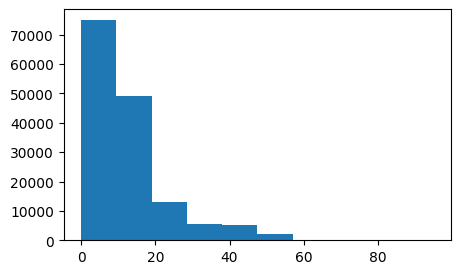

In [163]:
plt.figure(figsize=(5,3))
plt.hist(train_data['word_index_length'])

In [164]:
train_data[train_data['word_index_length'] < 20].count()

id                   126253
document             126253
label                126253
tokenized            126253
word_index           126253
word_index_length    126253
dtype: int64

In [165]:
train_data[train_data['word_index_length'] > 80]

,id,document,label,tokenized,word_index,word_index_length
65113,8520307,강추@강추@강추@강추@강추@강추@강추@강추@강추@강추@강추@강추@강추@강추@강추@강...,1,"[강추, @, 강추, @, 강추, @, 강추, @, 강추, @, 강추, @, 강추,...","[[5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5,...",93
116829,10002342,선유야 사랑해 우리 좀있다가 보자!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!...,1,"[선, 유야, 사랑, 해, 우리, 좀있다가, 보자, !!, ♥, !!, ♥, !!,...","[[3, 4, 4, 16, 3, 3, 6, 11, 6, 11, 6, 11, 6, 1...",88
126174,9230852,내평점은쓰레기임 진심평점줬더만일분만에삭제댓음티비서 내돈주고만원내고제돈주고내평썻더만 ...,0,"[내, 평점, 쓰레기, 임, 진심, 평점, 줬, 더, 만일분, 만에, 삭제, 댓, ...","[[11, 9, 4, 14, 4, 9, 7, 7, 3, 4, 7, 5, 9, 17,...",81
149047,7978306,임시완 보아 커플 최다니엘 김지원 커플 보러 가자 연장 고 고 고 고 고 고 고 고...,1,"[임시완, 보아, 커플, 최다니엘, 김지원, 커플, 보러, 가자, 연장, 고, 고,...","[[3, 22, 8, 3, 3, 8, 6, 3, 12, 6, 6, 6, 6, 6, ...",95


## word embedding

In [166]:
vocab_size = df_unique.shape[0]
vocab_size

104659

In [167]:
sequences = train_data['word_index'].apply(lambda x: x[0])

In [168]:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# 모델링

- pad_sequences의 max_sequence_length에 따라 Conv1D 레이어 필터 크기에 제한이 있음
    - 최대 시퀀스 길이 30에 필터 크기는 5 적용

In [169]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         10465900  
                                                                 
 conv1d_4 (Conv1D)           (None, None, 16)          8016      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, None, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, None, 16)          1296      
                                                                 
 global_max_pooling1d_2 (Gl  (None, 16)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 8)                

## 학습용/테스트용 데이터 분리

In [170]:
# 타겟 레이블
labels = train_data['label']

In [171]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [172]:
X_train.shape, X_test.shape

((119996, 30), (29999, 30))

## 학습

In [173]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=1)

3750/3750 [==============================] - 105s 28ms/step - loss: 0.6791 - accuracy: 0.5596


In [174]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

938/938 [==============================] - 1s 460us/step - loss: 0.6692 - accuracy: 0.5840
Test Loss: 0.6692
Test Accuracy: 0.5840


Loss, Accuracy.... 수치가 엉망...

# load_data() 구성

In [ ]:
def load_data(train_data, test_data, num_words=num_words):
    # [[YOUR CODE]]
    
    """
    - 데이터의 중복 제거
    - NaN 결측치 제거
    - 한국어 토크나이저로 토큰화
    - 불용어(Stopwords) 제거
    - 사전word_to_index 구성
    - 텍스트 스트링을 사전 인덱스 스트링으로 변환
    - X_train, y_train, X_test, y_test, word_to_index 리턴
    """
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

일단 이건 나중에...

# word2vec

In [353]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = './word2vec_ko.model'
wv_model = Word2VecKeyedVectors.load(word2vec_file_path)
word_vectors = wv_model.wv

In [356]:
vocabs            = word_vectors.key_to_index
word_vectors_list = [word_vectors[v] for v in vocabs]

# 결과

- 데이터로더(load_data) 함수화 못함
- word2vec으로 성능향상 못함